# Digital Elevation Models

* **Products used:** 
[dem_cop_30](https://explorer.digitalearth.africa/products/dem_cop_30), [dem_cop_90](https://explorer.digitalearth.africa/products/dem_cop_90), [dem_srtm](https://explorer.digitalearth.africa/products/dem_srtm), [dem_srtm_deriv](https://explorer.digitalearth.africa/products/dem_srtm_deriv)

## Background

**D**igital **E**levation **M**odels (DEMs) provide information on bare ground topography, that is, elevation irrespective of land cover such as buildings/trees. DEMs are often derived from Light Detection and Ranging (LiDAR) data sources. DEMs are used in several applications such as understanding how climatic variables change with topography.

**Important details:**

There are four DEM products available from the Open Data Cube. The [Copernicus products](https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198) come from the European Space Agency (ESA) and the [Shuttle Radar Topography Mission (SRTM)](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1-arc?qt-science_center_objects=0#qt-science_center_objects) products are from the United States Geological Survey (USGS):

1. Copernicus DEM 30 m: `dem_cop_30`, elevation data at 30 m resolution

2. Copernicus DEM 90 m: `dem_cop_90`, elevation data at 90 m resolution

3. DEM SRTM: `dem_srtm`, elevation data at 1-arc second (~30 m)

4. DEM SRTM Derivatives: `dem_srtm_deriv`, derivatives of the 1-arc second DEM which include:
    * **Slope (percent)**; this is the rate of elevation change, so mathematically speaking it is the first/primary derivative of elevation.
    * **Multi-resolution Valley Bottom Flatness (MrVBF)**; this identifies valley bottoms (areas of deposition). Zero values indicate erosional terrain and values ≥1 and indicate progressively larger areas of deposition.
    * **Multi-resolution Ridge Top Flatness (MrRTF)**; complementary to MrVBF, zero values indicate areas that are steep or low, and values ≥1 indicate progressively larger areas of high flat land.
    * For further details on how these measurements were calculated see the [DEM derivatives repository](https://github.com/digitalearthafrica/dem-derivative)

## Description

In this notebook we will load the Copernicus 30 m DEM and the DEM derivatives using `dc.load()`. Then we run through a short example analysis.

Topics covered include:
1. Inspecting the DEM product available in the datacube
2. Using the `dc.load()` function to load in DEM data
3. Plotting DEM and derivatives
4. An example analysis which compares temperature at high and low elevation

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from deafrica_tools.plotting import display_map
from deafrica_tools.load_era5 import load_era5
from odc.geo.xr import xr_reproject

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="DEM")

### List measurements

The table below lists the products and measurements available for the DEM datasets indexed within DE Africa's datacube. We can see that the first three products contain a single measure for elevation, expressed in metres above sea level. The derivatives product comprises percent slope, multi-resolution valley bottom flatness (mrvbf), and multi-resolution ridge top flatness (mrrtf). 

In [3]:
product_name = ['dem_cop_30', 'dem_cop_90', 'dem_srtm', 'dem_srtm_deriv'] 

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype  units   nodata aliases  \
product        measurement                                               
dem_cop_30     elevation    elevation  float32      1      NaN     NaN   
dem_cop_90     elevation    elevation  float32      1      NaN     NaN   
dem_srtm       elevation    elevation    int16  metre -32768.0     NaN   
dem_srtm_deriv mrvbf            mrvbf    int16      1 -32768.0     NaN   
               mrrtf            mrrtf    int16      1 -32768.0     NaN   
               slope            slope  float32      1  -9999.0     NaN   

                            add_offset  scale_factor  
product        measurement                            
dem_cop_30     elevation           NaN           NaN  
dem_cop_90     elevation           NaN           NaN  
dem_srtm       elevation           NaN           NaN  
dem_srtm_deriv mrvbf               NaN           NaN  
               mrrtf               NaN           NaN  
               slope               NaN           NaN

## Analysis parameters

* `lat`, `lon`: The central latitude and longitude to analyse (e.g. -3.0674, 37.355).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.
* `resolution`: We use 30 m here for the `dem_cop_30` product.

In [4]:
lat, lon = -3.0674, 37.3556 #Mt Kilimanjaro

buffer = 0.3

resolution=(-30, 30) 

measurements='elevation'

#convert the lat,lon,buffer into a range
lons = (lon - buffer, lon + buffer)
lats = (lat - buffer, lat + buffer)

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lons, y=lats)

## Load the Copernicus 30 m DEM data
When a product is re-projected to a different CRS and/or resolution, the new pixel grid may differ from the original input pixels by size, number and alignment. It is therefore necessary to apply a spatial "resampling" rule that allocates input pixel values into the new pixel grid.

By default, `dc.load()` resamples pixel values using "nearest neighbour" resampling, which allocates each new pixel with the value of the closest input pixel. Depending on the type of data and the analysis being run, this may not be the most appropriate choice (e.g. for continuous data such as elevation). The `resampling` parameter in `dc.load()` allows you to choose a custom resampling method from the following options: 
```
"nearest", "cubic", "bilinear", "cubic_spline", "lanczos", 
"average", "mode", "gauss", "max", "min", "med", "q1", "q3"
```
For Digital Elevation Models, all loaded data must be resampled using **"bilinear"** resampling. Bilinear interpolation calculates the value for an output raster cell by averaging the values of the four closest input cell centers. This weighted average is adjusted based on the distance of each input cell from the center of the output cell. This method produces a smoother surface compared to the nearest neighbor technique.

In [6]:
#set up daatcube query object
query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'output_crs': 'epsg:6933',
    'measurements':measurements,
    'resampling': "bilinear"
}

#load the dem 30 m product
ds = dc.load(product="dem_cop_30", **query).squeeze()
print(ds)

<xarray.Dataset> Size: 20MB
Dimensions:      (y: 2549, x: 1931)
Coordinates:
  * y            (y) float64 20kB -3.529e+05 -3.529e+05 ... -4.293e+05
  * x            (x) float64 15kB 3.575e+06 3.575e+06 ... 3.633e+06 3.633e+06
    time         datetime64[ns] 8B 2000-01-01T12:00:00
    spatial_ref  int32 4B 6933
Data variables:
    elevation    (y, x) float32 20MB 1.147e+03 1.147e+03 ... 852.9 856.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Plot elevation

We can generate a basic plot of elevation below. The summit of Mt Kilimanjaro is 5,895m.

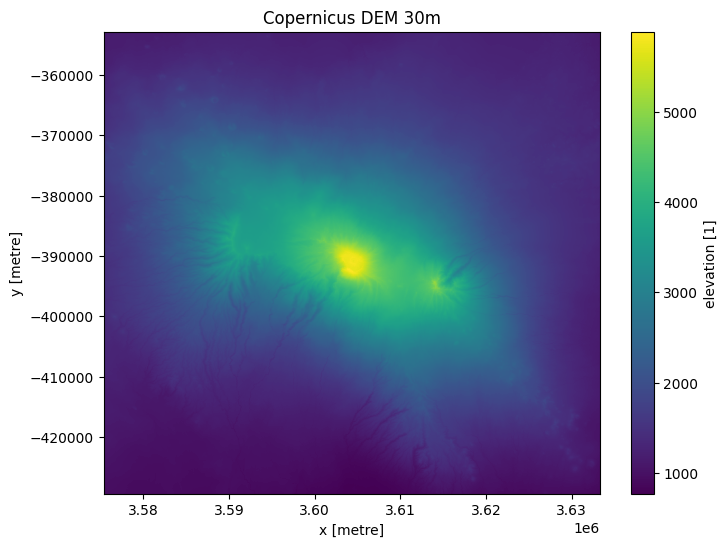

In [7]:
ds.elevation.plot(figsize=(8,6))
plt.title('Copernicus DEM 30m');

## Load DEM deriviatives

Now we can load the derivative dataset with the same parameters, except measurements.

In [8]:
# We just need to change the measurements parameter, lats, lon, crs etc. can remain the same. 
measurements=['mrvbf', 'mrrtf', 'slope'] 

query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'output_crs': 'epsg:6933',
    'measurements':measurements,
    'resampling': "bilinear"
}

ds_deriv = dc.load(product="dem_srtm_deriv", **query).squeeze()
print(ds_deriv)

<xarray.Dataset> Size: 39MB
Dimensions:      (y: 2549, x: 1931)
Coordinates:
  * y            (y) float64 20kB -3.529e+05 -3.529e+05 ... -4.293e+05
  * x            (x) float64 15kB 3.575e+06 3.575e+06 ... 3.633e+06 3.633e+06
    time         datetime64[ns] 8B 2000-01-01T12:00:00
    spatial_ref  int32 4B 6933
Data variables:
    mrvbf        (y, x) int16 10MB 2 1 0 0 3 4 4 3 3 3 3 ... 1 0 0 0 1 2 2 2 1 1
    mrrtf        (y, x) int16 10MB 0 0 1 1 0 0 0 0 0 0 1 ... 2 1 0 0 0 0 0 0 0 0
    slope        (y, x) float32 20MB 7.383 12.15 13.24 ... 4.29 8.271 9.148
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Plot derivatives

Plotting the three derivative measurements below shows areas of greater steepness around Mt Kilimanjaro. Most of the mountain has a 0 value for valley bottom and ridge tip flatness, whereas surrounding areas are identified as valleys and flat ridge tops.

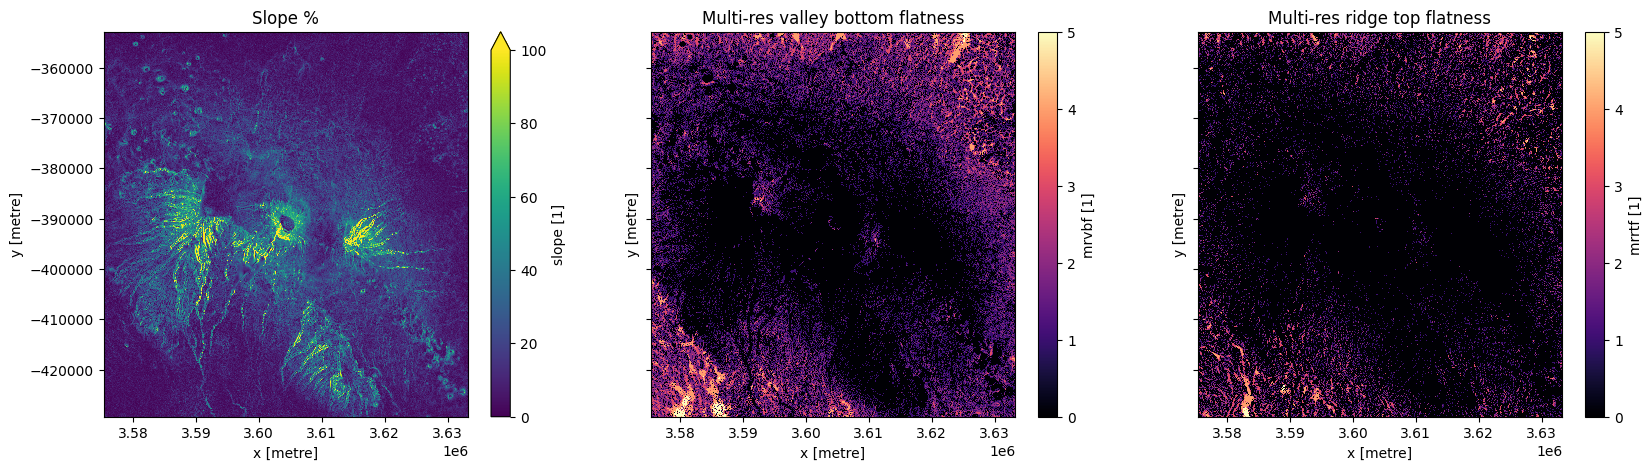

In [9]:
fig,ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
ds_deriv.slope.plot(ax=ax[0], vmax=100)
ds_deriv.mrvbf.plot(ax=ax[1], cmap='magma')
ds_deriv.mrrtf.plot(ax=ax[2], cmap='magma')

ax[0].set_title('Slope %')
ax[1].set_title('Multi-res valley bottom flatness')
ax[2].set_title('Multi-res ridge top flatness');

## Analysis example: masking based on elevation

We can use elevation information to select or mask areas for analysis. In this example, we will compare climatic information between higher and lower elevation at the Virunga Mountains, a chain of volcanoes along the border of Rwanda, the Democratic Republic of the Congo, and Uganda.

Below we set up some new analysis parameters:

* `lat`, `lon`: The central latitude and longitude to analyse for the Virunga Mountains (-1.4310, 29.5262).
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
* `resolution`: We use 90 m here with the `dem_cop_90` product for faster loading and computation times.

In [10]:
lat, lon = -1.4310, 29.5262
buffer = 0.2

resolution=(-90, 90) 

measurements='elevation'

#convert the lat,lon,buffer into a range
lons = (lon - buffer, lon + buffer)
lats = (lat - buffer, lat + buffer)

## View the selected location

In [11]:
display_map(x=lons, y=lats)

### Load the Copernicus 90m DEM

In [12]:
query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'output_crs': 'epsg:6933',
    'measurements':measurements,
    'resampling': "bilinear"
}

#load the dem
ds = dc.load(product="dem_cop_90", **query).squeeze() # Using 90 m product for better computation times

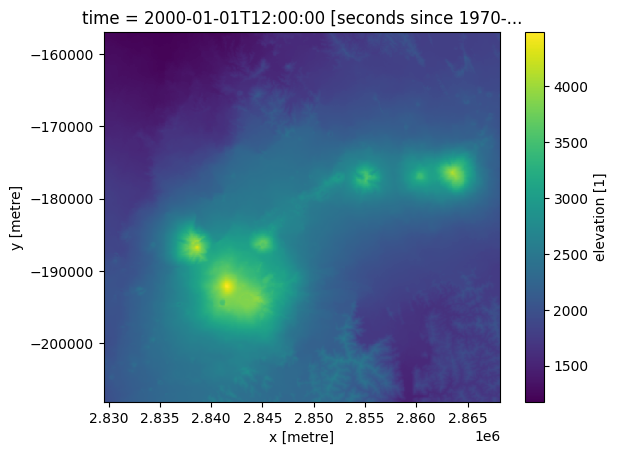

In [13]:
ds.elevation.plot();

### Mask analysis to high and low elevation

For this analysis, we will split the dataset into areas above and below 2,000m in elevation. In the plot below we can see that this separates the chain of volcanoes from surrounding lowland.

In [14]:
ds = ds.assign(high=xr.where(ds.elevation >= 2000, 1, 0))
ds = ds.assign(low=xr.where(ds.elevation < 2000, 1, 0))
print(ds)

<xarray.Dataset> Size: 5MB
Dimensions:      (y: 568, x: 430)
Coordinates:
  * y            (y) float64 5kB -1.57e+05 -1.571e+05 ... -2.079e+05 -2.08e+05
  * x            (x) float64 3kB 2.83e+06 2.83e+06 ... 2.868e+06 2.868e+06
    time         datetime64[ns] 8B 2000-01-01T12:00:00
    spatial_ref  int32 4B 6933
Data variables:
    elevation    (y, x) float32 977kB 1.236e+03 1.235e+03 ... 1.791e+03
    high         (y, x) int64 2MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    low          (y, x) int64 2MB 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


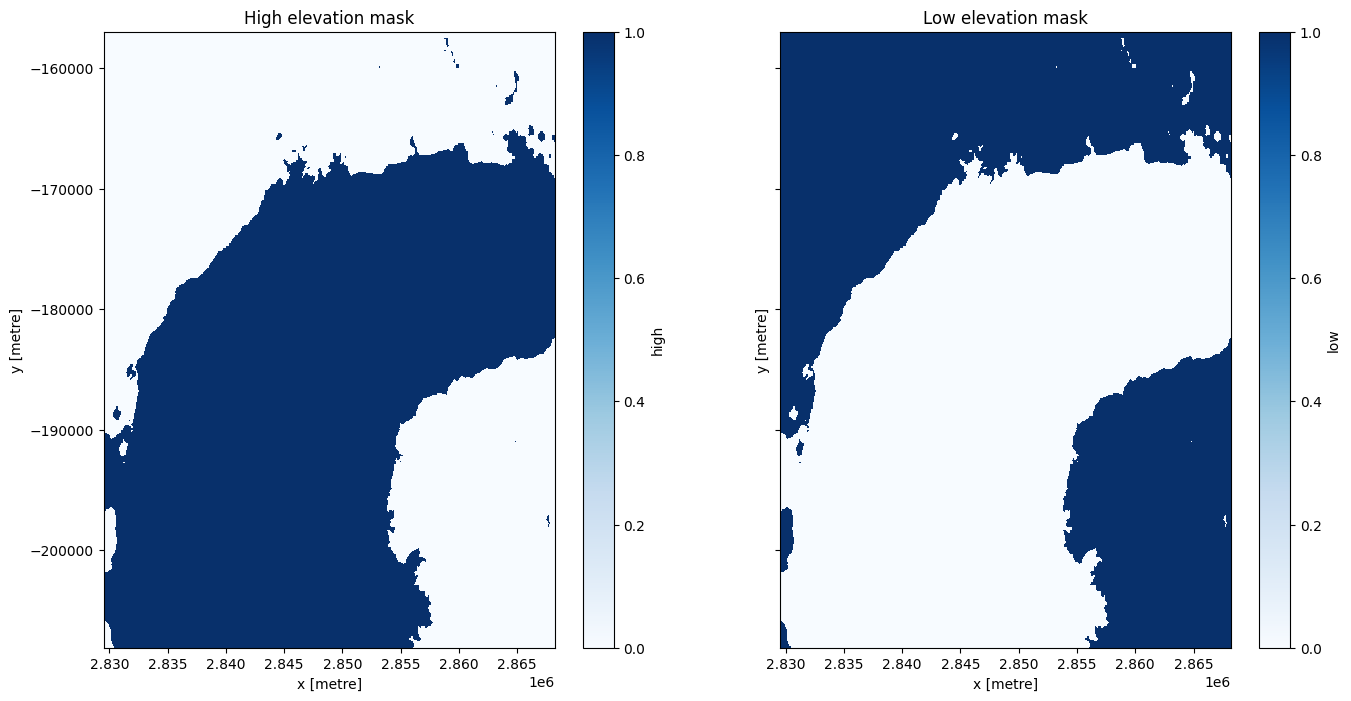

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ds.high.plot(cmap='Blues', ax=axes[0])
ds.low.plot(cmap='Blues', ax=axes[1])
axes[0].set_title('High elevation mask')
axes[1].set_title('Low elevation mask');

### Load temperature data and compare between high and low elevation

We will use the `load_era5` function to load temperature data. More information on loading and using climate data can be found in the [Climate_Data_ERA5_AWS Datasets](Climate_Data_ERA5_AWS.ipynb) notebook.

In [16]:
time = time = '2021-01', '2021-03'  # first three months of 2021 
temp_var = 'air_temperature_at_2_metres'
temp_mean = load_era5(temp_var, lats, lons, time, reduce_func=np.mean, resample='1D').compute()-273.15 # Convert Kelvin to Celsius

To make our calculation we will need to reproject the climate data so it matches the elevation data. We use the `xr_reproject` function to do this. More information on reprojecting datacube data is available [here](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Reprojecting_data.html).

In [19]:
temp_mean_reprojected = xr_reproject(src=temp_mean, how=ds.odc.geobox, resampling="average")

We can see that average daily temperature tends to be lower at the altitudes >2,000m for our analysis area, according to the ERA5 reanalysis product.

/tmp/ipykernel_1629/2702343169.py:1: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = ds.merge(temp_mean_reprojected, ds)


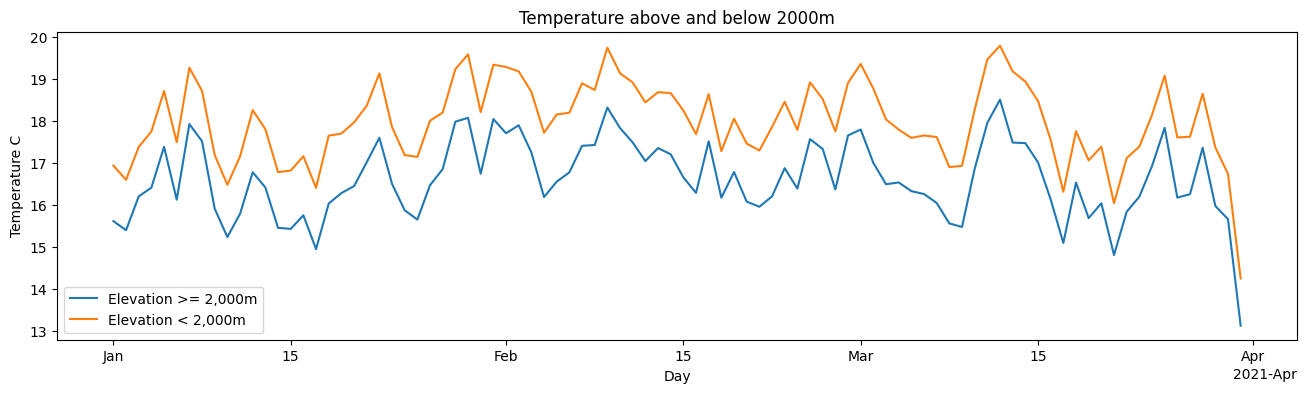

In [20]:
ds = ds.merge(temp_mean_reprojected, ds)
ds_high = ds.where(ds.squeeze().high)
high_mean_airtemp = ds_high.air_temperature_at_2_metres.mean(['x','y'])
ds_low = ds.where(ds.squeeze().low)
low_mean_airtemp = ds_low.air_temperature_at_2_metres.mean(['x','y'])

ds_high.air_temperature_at_2_metres.mean(['x','y']).plot(figsize = (16,4), label='Elevation >= 2,000m');
ds_low.air_temperature_at_2_metres.mean(['x','y']).plot(label='Elevation < 2,000m');
plt.legend();
plt.xlabel('Day');
plt.ylabel('Temperature C')
plt.title('Temperature above and below 2000m');

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [21]:
print(datacube.__version__)

1.8.20


**Last tested:**

In [22]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2026-01-12'